## Notes
* This notebook has implementations of `Backprop`, `feedback alignment` (random backprop), `direct feedback alignment` and `feedforward` updates for a neural net with 1 hidden layer, `sigmoid` activations and `Quadratic` function. In this case we code backprop using the final update equations.  
## References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)

In [1]:
import os, time
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline

## Hide code

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25

In [26]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
batch_size = 10
iterations = 400000
epochs = (iterations*batch_size) / (mnist.train.images.shape[0])
print('Total number of epochs:{}'.format(epochs))

Total number of epochs:72


In [6]:
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

$tanh(x) = \frac{(e^{x} – e^{-x})}{(e^{x} + e^{-x})}$

$d\frac{tanh(x)}{dx} = 1 – (tanh(x))^{2}$

$\sigma(x) = \frac{1.0}{1 + e^{-x}}$

$d\frac{\sigma(x)}{dx} = \sigma(x)*(1 - \sigma(x))$

In [7]:
a_1 = tf.placeholder(tf.float32, [784, None], name = 'Input_batch')
y = tf.placeholder(tf.float32, [10, None], name = 'output_batch')

n_middle = 80
with tf.name_scope('hidden_layer'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(784 + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(784 + n_middle))
    w_2 = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2')
    b_2 = tf.Variable(tf.zeros([n_middle,1]), name = 'b_2')
with tf.name_scope('output_layer'):
    low = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_middle + 10))
    w_3 = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3')
    b_3 = tf.Variable(tf.zeros([10,1]), name = 'b_3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

def tanh(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

with tf.name_scope('hidden_lyr_ffwd'):
    z_2 = tf.add(tf.matmul(w_2,a_1,name = 'w_2xa_1'), b_2, name = 'z_2')
    a_2 = sigma(z_2)
with tf.name_scope('op_lyr_ffwd'):
    z_3 = tf.add(tf.matmul(w_3,a_2, name = 'w_3xa_2'),b_3, name = 'z_3')
    a_3 = sigma(z_3)


dc_da = -tf.subtract(y,a_3, name = 'y_minus_a_3')
cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=0), name = 'cost_calc')

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

with tf.name_scope('bprop_op_lyr'):
    d_z_3 = tf.multiply(dc_da,sigmaprime(z_3), name = 'delta3')
    d_b_3 = d_z_3
    d_w_3 = tf.matmul(d_z_3,tf.transpose(a_2), name='delta_w3')
    
with tf.name_scope('bprop_hidden_lyr'):
    d_z_2 = tf.multiply(tf.matmul(tf.transpose(w_3),d_z_3, name = 'w_3Txdelta3'), sigmaprime(z_2), name = 'delta2')
    d_b_2 = d_z_2
    d_w_2 = tf.matmul(d_z_2,tf.transpose(a_1), name = 'delta_w2')
    
eta = tf.constant(0.15)
step = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/batch_size, d_w_2)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2, axis=[1]),axis=-1))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/batch_size, d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[1]),axis=-1))))
]

with tf.name_scope('acc_calc'):
    acct_mat = tf.equal(tf.argmax(a_3, 0), tf.argmax(y, 0))
    acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

In [8]:
train_accuracies = []
train_costs = []
val_accuracies = []
val_costs = []
best_val = 0
best_params = None
for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.transpose()
    batch_ys = batch_ys.transpose()
    sess.run(step, feed_dict = {a_1: batch_xs,y:batch_ys}, 
             options=run_options,run_metadata=run_metadata)
    
    if((i*batch_size) % (mnist.train.images.shape[0]) == 0):
        print('Epoch:{}'.format((i*batch_size / mnist.train.images.shape[0])))
        train_cost = sess.run(cost, feed_dict = {a_1 : mnist.train.images.transpose(),
                                                y : mnist.train.labels.transpose()} )
        train_costs.append(train_cost)
        train_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.train.images.transpose(),
                        y : mnist.train.labels.transpose()})
        train_accuracies.append(train_acc / 55000.0)
        print('training cost:{} and training accuracy:{}'.format(train_cost, train_acc / 55000.0))
        
        val_cost = sess.run(cost, feed_dict = {a_1 : mnist.validation.images.transpose(),
                                                y : mnist.validation.labels.transpose()} )
        val_costs.append(val_cost)
        val_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.validation.images.transpose(),
                        y : mnist.validation.labels.transpose()})
        val_accuracies.append(val_acc / 5000.0)
        if(val_acc>best_val):
            best_val = val_acc
            best_params = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc / 5000.0))
        
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Final test accuracy is:{}'.format(test_acc / 10000.0))

best_step = [tf.assign(w_2,best_params[0][0]), tf.assign(b_2,best_params[0][1]),tf.assign(w_3,best_params[1][0]),\
    tf.assign(b_3,best_params[1][1])]

sess.run(best_step)
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Test accuracy corresp to best val acc:{}'.format(test_acc / 10000.0))

Epoch:0
training cost:1.88136816025 and training accuracy:0.0979818181818
validation cost:1.88835310936 and validation accuracy:0.0924
Epoch:1
training cost:0.0868699848652 and training accuracy:0.907454545455
validation cost:0.0815329551697 and validation accuracy:0.9172
Epoch:2
training cost:0.0686834976077 and training accuracy:0.924509090909
validation cost:0.0644076094031 and validation accuracy:0.9318
Epoch:3
training cost:0.061042919755 and training accuracy:0.932709090909
validation cost:0.0576266162097 and validation accuracy:0.9414
Epoch:4
training cost:0.053731624037 and training accuracy:0.941327272727
validation cost:0.0505182668567 and validation accuracy:0.9474
Epoch:5
training cost:0.0491364300251 and training accuracy:0.946236363636
validation cost:0.0469691455364 and validation accuracy:0.9524
Epoch:6
training cost:0.0456451624632 and training accuracy:0.9508
validation cost:0.0440608002245 and validation accuracy:0.9558
Epoch:7
training cost:0.0428604669869 and train

Epoch:60
training cost:0.0124963670969 and training accuracy:0.988054545455
validation cost:0.0249846614897 and validation accuracy:0.9728
Epoch:61
training cost:0.0122818890959 and training accuracy:0.988363636364
validation cost:0.0249356497079 and validation accuracy:0.9712
Epoch:62
training cost:0.012095070444 and training accuracy:0.988290909091
validation cost:0.0247366484255 and validation accuracy:0.973
Epoch:63
training cost:0.0120143042877 and training accuracy:0.988618181818
validation cost:0.0249569602311 and validation accuracy:0.9716
Epoch:64
training cost:0.0119010889903 and training accuracy:0.988618181818
validation cost:0.024888785556 and validation accuracy:0.9708
Epoch:65
training cost:0.0116705326363 and training accuracy:0.988745454545
validation cost:0.0246290881187 and validation accuracy:0.9716
Epoch:66
training cost:0.0114575140178 and training accuracy:0.988781818182
validation cost:0.0245758201927 and validation accuracy:0.9724
Epoch:67
training cost:0.01134

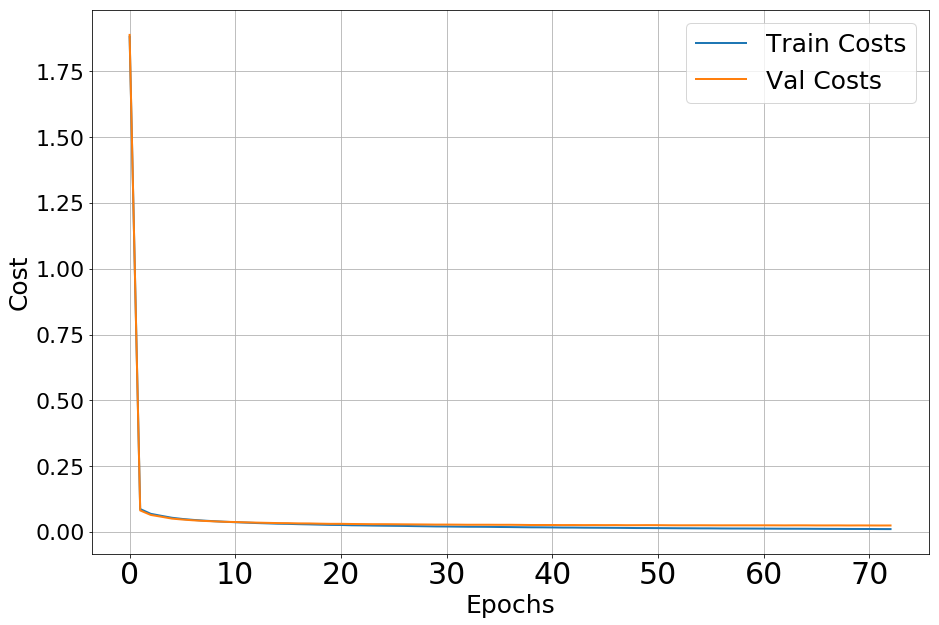

In [9]:
plt.plot(train_costs, label="Train Costs")
plt.plot(val_costs, label="Val Costs")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

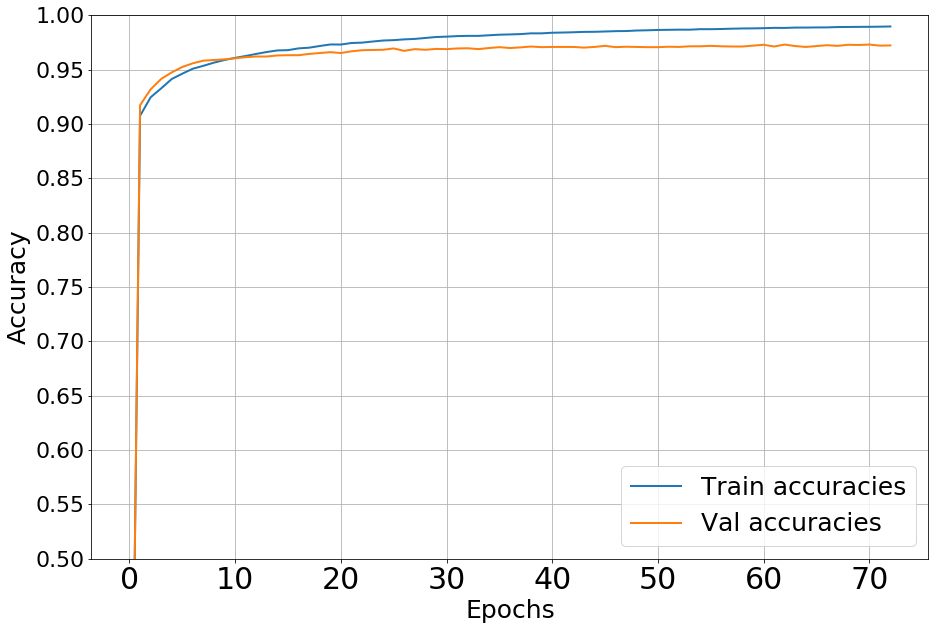

In [10]:
plt.plot(train_accuracies, label="Train accuracies")
plt.plot(val_accuracies, label="Val accuracies")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.05*i for i in range(1,21)])
plt.ylim(0.5,1.0)
plt.grid()
plt.legend()
plt.show()

## Feedback alignment (Random backprop or FA)

In [11]:
sess.close()
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

In [12]:
a_1 = tf.placeholder(tf.float32, [784, None], name = 'Input_batch')
y = tf.placeholder(tf.float32, [10, None], name = 'output_batch')

with tf.name_scope('hidden_layer'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(784 + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(784 + n_middle))
    w_2 = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2')
    w_2_r = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2_r')
    b_2 = tf.Variable(tf.zeros([n_middle,1]), name = 'b_2')
with tf.name_scope('output_layer'):
    low = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_middle + 10))
    w_3 = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3')
    w_3_r = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3_r')
    b_3 = tf.Variable(tf.zeros([10,1]), name = 'b_3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

with tf.name_scope('hidden_lyr_ffwd'):
    z_2 = tf.add(tf.matmul(w_2,a_1,name = 'w_2xa_1'), b_2, name = 'z_2')
    a_2 = sigma(z_2)
with tf.name_scope('op_lyr_ffwd'):
    z_3 = tf.add(tf.matmul(w_3,a_2, name = 'w_3xa_2'),b_3, name = 'z_3')
    a_3 = sigma(z_3)


dc_da = -tf.subtract(y,a_3, name = 'y_minus_a_3')
cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=0), name = 'cost_calc')

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

with tf.name_scope('bprop_op_lyr'):
    d_z_3 = tf.multiply(dc_da,sigmaprime(z_3), name = 'delta3')
    d_b_3 = d_z_3
    d_w_3 = tf.matmul(d_z_3,tf.transpose(a_2), name='delta_w3')
    
with tf.name_scope('bprop_hidden_lyr'):
    ### random backprop (NOTICE THAT WE'RE USING A FIXED RANDOM MATRIX w_3_r TO CALCULATE d_z_2 (delta2))
    d_z_2_r = tf.multiply(tf.matmul(tf.transpose(w_3_r),d_z_3, name = 'w_3_rTxdelta3'), sigmaprime(z_2), 
                          name = 'delta2_r')
    d_b_2_r = d_z_2_r
    d_w_2_r = tf.matmul(d_z_2_r,tf.transpose(a_1), name = 'delta_w2_r')

step_r = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/batch_size, d_w_2_r)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2_r, axis=[1]),axis=-1))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/batch_size, d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[1]),axis=-1))))
]

with tf.name_scope('acc_calc'):
    acct_mat = tf.equal(tf.argmax(a_3, 0), tf.argmax(y, 0))
    acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

In [13]:
train_accuracies_r = []
train_costs_r = []
val_accuracies_r = []
val_costs_r = []
best_val_r = 0
best_params_r = None
for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.transpose()
    batch_ys = batch_ys.transpose()
    #print(batch_xs.shape, batch_ys.shape)
    sess.run(step_r, feed_dict = {a_1: batch_xs,
                y : batch_ys}, options=run_options,run_metadata=run_metadata)
    
    if((i*batch_size) % (mnist.train.images.shape[0]) == 0):
        print('Epoch:{}'.format((i*batch_size / mnist.train.images.shape[0])))
        train_cost = sess.run(cost, feed_dict = {a_1 : mnist.train.images.transpose(),
                                                y : mnist.train.labels.transpose()} )
        train_costs_r.append(train_cost)
        train_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.train.images.transpose(),
                        y : mnist.train.labels.transpose()})
        train_accuracies_r.append(train_acc / 55000.0)
        print('training cost:{} and training accuracy:{}'.format(train_cost, train_acc / 55000.0))
        
        val_cost = sess.run(cost, feed_dict = {a_1 : mnist.validation.images.transpose(),
                                                y : mnist.validation.labels.transpose()} )
        val_costs_r.append(val_cost)
        val_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.validation.images.transpose(),
                        y : mnist.validation.labels.transpose()})
        val_accuracies_r.append(val_acc / 5000.0)
        if(val_acc>best_val_r):
            best_val_r = val_acc
            best_params_r = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc / 5000.0))
        
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Final test accuracy is:{}'.format(test_acc / 10000.0))

best_step = [tf.assign(w_2,best_params_r[0][0]), tf.assign(b_2,best_params_r[0][1]),tf.assign(w_3,best_params_r[1][0]),\
    tf.assign(b_3,best_params_r[1][1])]

sess.run(best_step)
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Test accuracy corresp to best val acc:{}'.format(test_acc / 10000.0))

Epoch:0
training cost:1.56176161766 and training accuracy:0.0723818181818
validation cost:1.550385952 and validation accuracy:0.0708
Epoch:1
training cost:0.146258667111 and training accuracy:0.795018181818
validation cost:0.140980347991 and validation accuracy:0.8018
Epoch:2
training cost:0.0866175591946 and training accuracy:0.905145454545
validation cost:0.080401673913 and validation accuracy:0.9138
Epoch:3
training cost:0.0716716498137 and training accuracy:0.918254545455
validation cost:0.0669303163886 and validation accuracy:0.9254
Epoch:4
training cost:0.0640884414315 and training accuracy:0.9268
validation cost:0.060098156333 and validation accuracy:0.9328
Epoch:5
training cost:0.0592671558261 and training accuracy:0.933145454545
validation cost:0.0560882948339 and validation accuracy:0.9362
Epoch:6
training cost:0.05538238585 and training accuracy:0.937581818182
validation cost:0.0520407855511 and validation accuracy:0.941
Epoch:7
training cost:0.0519393384457 and training acc

Epoch:60
training cost:0.019165661186 and training accuracy:0.980309090909
validation cost:0.0268678870052 and validation accuracy:0.971
Epoch:61
training cost:0.0188942626119 and training accuracy:0.980581818182
validation cost:0.0266854763031 and validation accuracy:0.9706
Epoch:62
training cost:0.0187833942473 and training accuracy:0.980636363636
validation cost:0.0266746710986 and validation accuracy:0.9702
Epoch:63
training cost:0.018547065556 and training accuracy:0.980981818182
validation cost:0.0266353264451 and validation accuracy:0.9706
Epoch:64
training cost:0.0185525361449 and training accuracy:0.980981818182
validation cost:0.0267069917172 and validation accuracy:0.9702
Epoch:65
training cost:0.0183246731758 and training accuracy:0.981181818182
validation cost:0.0264667477459 and validation accuracy:0.9702
Epoch:66
training cost:0.0181571170688 and training accuracy:0.981472727273
validation cost:0.0264723692089 and validation accuracy:0.9706
Epoch:67
training cost:0.01791

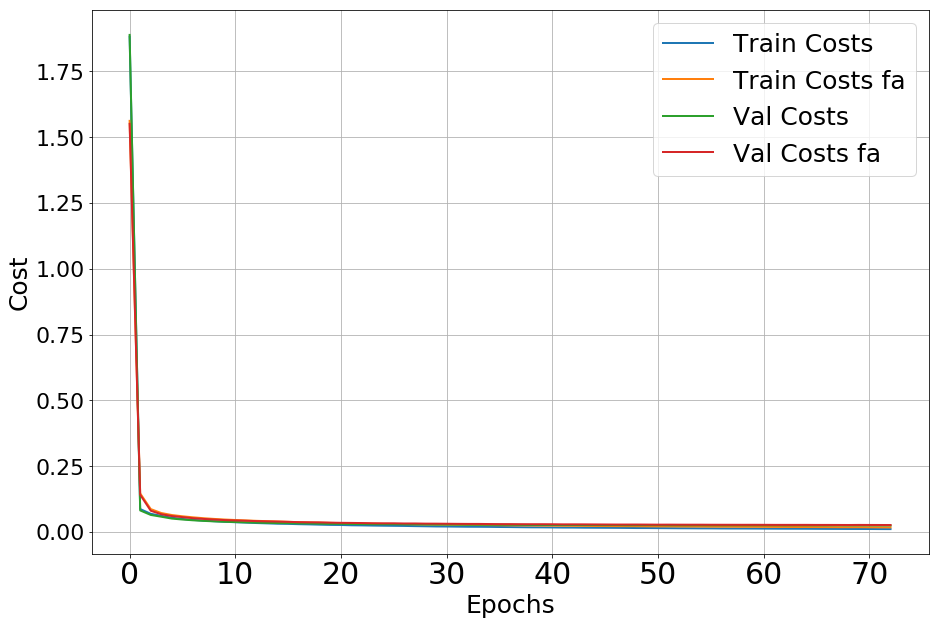

In [14]:
plt.plot(train_costs, label="Train Costs")
plt.plot(train_costs_r, label="Train Costs fa")
plt.plot(val_costs, label="Val Costs")
plt.plot(val_costs_r, label="Val Costs fa")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

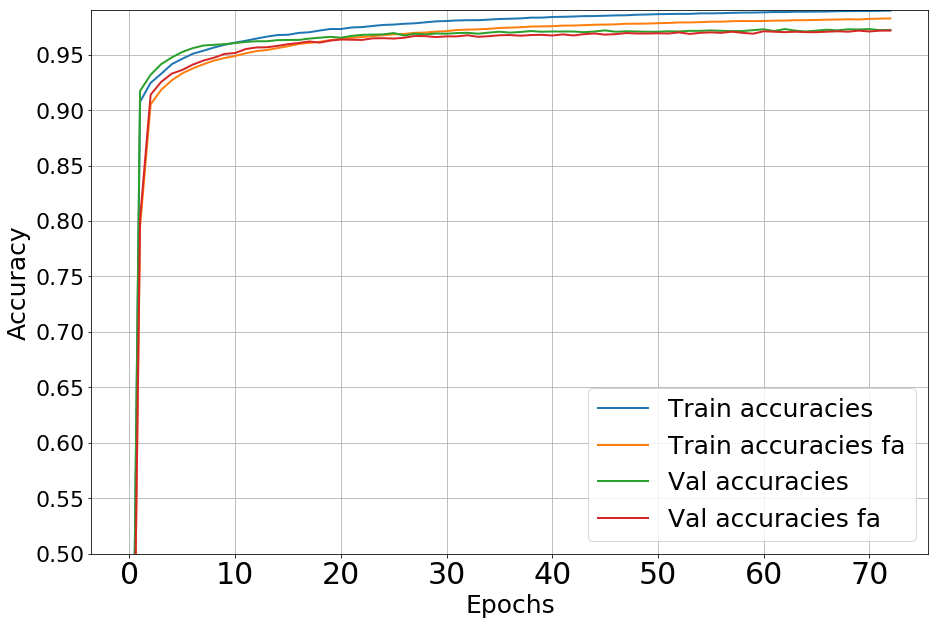

In [15]:
plt.plot(train_accuracies, label="Train accuracies")
plt.plot(train_accuracies_r, label="Train accuracies fa")
plt.plot(val_accuracies, label="Val accuracies")
plt.plot(val_accuracies_r, label="Val accuracies fa")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.05*i for i in range(1,21)])
plt.ylim(0.5,0.99)
plt.grid()
plt.legend()
plt.show()

## Direct feedback alignment (DFA)

In [16]:
sess.close()
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

In [17]:
a_1 = tf.placeholder(tf.float32, [784, None], name = 'Input_batch')
y = tf.placeholder(tf.float32, [10, None], name = 'output_batch')

with tf.name_scope('hidden_layer'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(784 + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(784 + n_middle))
    w_2 = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2')
    low_df = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high_df = 4*tf.math.sqrt(6.0/(n_middle + 10))
    w_2_df = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low_df,maxval=high_df), name = 'W_2_df')
    b_2 = tf.Variable(tf.zeros([n_middle,1]), name = 'b_2')
with tf.name_scope('output_layer'):
    low = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_middle + 10))
    w_3 = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3')
    w_3_df = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3_df')
    b_3 = tf.Variable(tf.zeros([10,1]), name = 'b_3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

with tf.name_scope('hidden_lyr_ffwd'):
    z_2 = tf.add(tf.matmul(w_2,a_1,name = 'w_2xa_1'), b_2, name = 'z_2')
    a_2 = sigma(z_2)
with tf.name_scope('op_lyr_ffwd'):
    z_3 = tf.add(tf.matmul(w_3,a_2, name = 'w_3xa_2'),b_3, name = 'z_3')
    a_3 = sigma(z_3)


dc_da = -tf.subtract(y,a_3, name = 'y_minus_a_3')
cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=0), name = 'cost_calc')

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

with tf.name_scope('bprop_op_lyr'):
    d_z_3 = tf.multiply(dc_da,sigmaprime(z_3), name = 'delta3')
    d_b_3 = d_z_3
    d_w_3 = tf.matmul(d_z_3,tf.transpose(a_2), name='delta_w3')
    
with tf.name_scope('bprop_hidden_lyr'):
    d_z_2_df = tf.multiply(tf.matmul(tf.transpose(w_2_df),d_z_3, name = 'w_2_dfTxdelta3'), sigmaprime(z_2), 
                          name = 'delta2_df') #<-- DIRECT FEEDBACK FROM OP LAYER
    d_b_2_df = d_z_2_df
    d_w_2_df = tf.matmul(d_z_2_df,tf.transpose(a_1), name = 'delta_w2_df')

step_df = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/batch_size, d_w_2_df)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2_df, axis=[1]),axis=-1))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/batch_size, d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[1]),axis=-1))))
]

with tf.name_scope('acc_calc'):
    acct_mat = tf.equal(tf.argmax(a_3, 0), tf.argmax(y, 0))
    acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

In [18]:
train_accuracies_df = []
train_costs_df = []
val_accuracies_df = []
val_costs_df = []
best_val_df = 0
best_params_df = None
for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.transpose()
    batch_ys = batch_ys.transpose()
    #print(batch_xs.shape, batch_ys.shape)
    sess.run(step_df, feed_dict = {a_1: batch_xs,
                y : batch_ys}, options=run_options,run_metadata=run_metadata)
    
    if((i*batch_size) % (mnist.train.images.shape[0]) == 0):
        print('Epoch:{}'.format((i*batch_size / mnist.train.images.shape[0])))
        train_cost = sess.run(cost, feed_dict = {a_1 : mnist.train.images.transpose(),
                                                y : mnist.train.labels.transpose()} )
        train_costs_df.append(train_cost)
        train_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.train.images.transpose(),
                        y : mnist.train.labels.transpose()})
        train_accuracies_df.append(train_acc / 55000.0)
        print('training cost:{} and training accuracy:{}'.format(train_cost, train_acc / 55000.0))
        
        val_cost = sess.run(cost, feed_dict = {a_1 : mnist.validation.images.transpose(),
                                                y : mnist.validation.labels.transpose()} )
        val_costs_df.append(val_cost)
        val_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.validation.images.transpose(),
                        y : mnist.validation.labels.transpose()})
        val_accuracies_df.append(val_acc / 5000.0)
        if(val_acc>best_val_df):
            best_val_df = val_acc
            best_params_df = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc / 5000.0))
        
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Final test accuracy is:{}'.format(test_acc / 10000.0))

best_step = [tf.assign(w_2,best_params_df[0][0]), tf.assign(b_2,best_params_df[0][1]),tf.assign(w_3,best_params_df[1][0]),\
    tf.assign(b_3,best_params_df[1][1])]

sess.run(best_step)
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Test accuracy corresp to best val acc:{}'.format(test_acc / 10000.0))

Epoch:0
training cost:1.85482752323 and training accuracy:0.0970181818182
validation cost:1.84510111809 and validation accuracy:0.1096
Epoch:1
training cost:0.145230993629 and training accuracy:0.795672727273
validation cost:0.13850222528 and validation accuracy:0.8088
Epoch:2
training cost:0.0794001072645 and training accuracy:0.909181818182
validation cost:0.0743492171168 and validation accuracy:0.9168
Epoch:3
training cost:0.0688589140773 and training accuracy:0.9206
validation cost:0.0642135515809 and validation accuracy:0.9262
Epoch:4
training cost:0.0624727457762 and training accuracy:0.928054545455
validation cost:0.0586949326098 and validation accuracy:0.9328
Epoch:5
training cost:0.0578128919005 and training accuracy:0.932945454545
validation cost:0.0541456863284 and validation accuracy:0.9394
Epoch:6
training cost:0.0541679523885 and training accuracy:0.938054545455
validation cost:0.0510092414916 and validation accuracy:0.9436
Epoch:7
training cost:0.0512237288058 and traini

Epoch:60
training cost:0.01987728104 and training accuracy:0.979036363636
validation cost:0.0291199460626 and validation accuracy:0.968
Epoch:61
training cost:0.0196403674781 and training accuracy:0.9792
validation cost:0.02902264148 and validation accuracy:0.9676
Epoch:62
training cost:0.0194979477674 and training accuracy:0.979381818182
validation cost:0.0290857516229 and validation accuracy:0.9678
Epoch:63
training cost:0.0192287117243 and training accuracy:0.979927272727
validation cost:0.0289477836341 and validation accuracy:0.9672
Epoch:64
training cost:0.0192077066749 and training accuracy:0.979927272727
validation cost:0.0290406197309 and validation accuracy:0.9678
Epoch:65
training cost:0.0191110670567 and training accuracy:0.979909090909
validation cost:0.0289951562881 and validation accuracy:0.9674
Epoch:66
training cost:0.0188062116504 and training accuracy:0.980109090909
validation cost:0.0287693962455 and validation accuracy:0.9686
Epoch:67
training cost:0.0187609214336 a

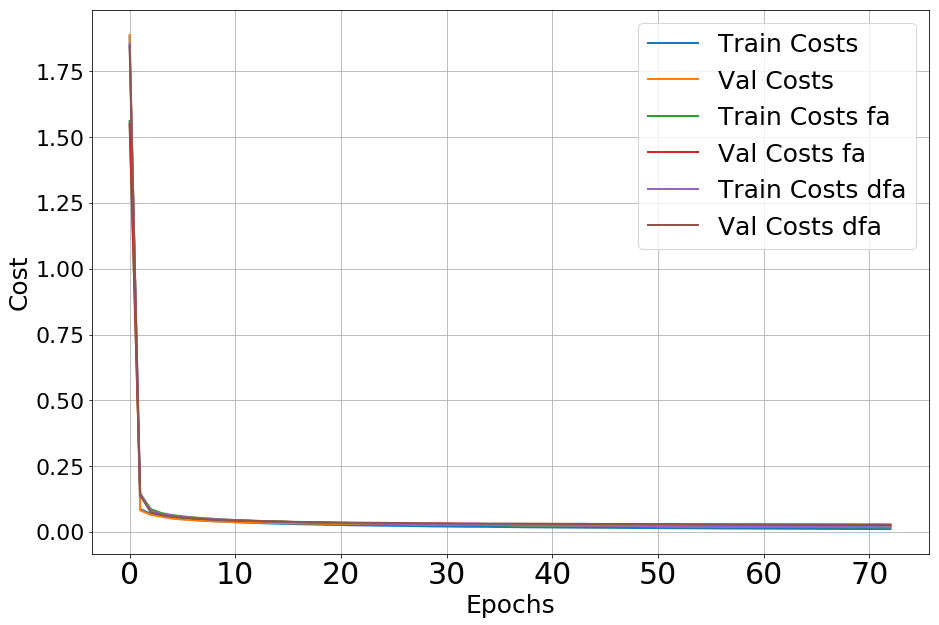

In [19]:
plt.plot(train_costs, label="Train Costs")
plt.plot(val_costs, label="Val Costs")
plt.plot(train_costs_r, label="Train Costs fa")
plt.plot(val_costs_r, label="Val Costs fa")
plt.plot(train_costs_df, label="Train Costs dfa")
plt.plot(val_costs_df, label="Val Costs dfa")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

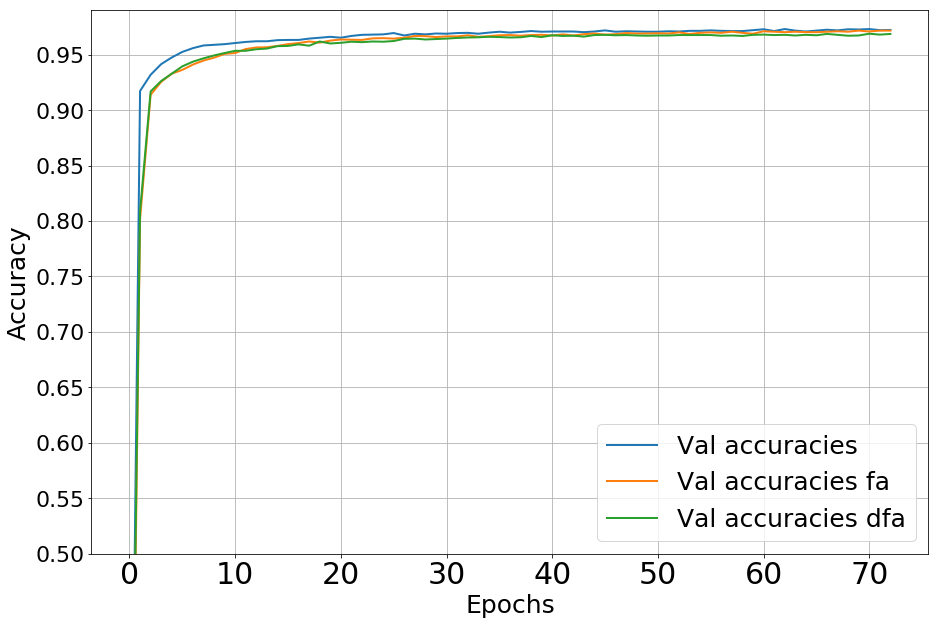

In [20]:
#plt.plot(train_accuracies, label="Train accuracies")
plt.plot(val_accuracies, label="Val accuracies")
#plt.plot(train_accuracies_r, label="Train accuracies fa")
plt.plot(val_accuracies_r, label="Val accuracies fa")
#plt.plot(train_accuracies_df, label="Train accuracies dfa")
plt.plot(val_accuracies_df, label="Val accuracies dfa")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.05*i for i in range(1,21)])
plt.ylim(0.5,0.99)
plt.grid()
plt.legend()
plt.show()

## Feedforward updates (FF)


In [21]:
sess.close()
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

In [22]:
a_1 = tf.placeholder(tf.float32, [784, None], name = 'Input_batch')
y = tf.placeholder(tf.float32, [10, None], name = 'output_batch')

with tf.name_scope('hidden_layer'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(784 + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(784 + n_middle))
    w_2 = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2')
    low_ff = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high_ff = 4*tf.math.sqrt(6.0/(n_middle + 10))
    w_2_ff = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low_df,maxval=high_df), name = 'W_2_df')
    b_2 = tf.Variable(tf.zeros([n_middle,1]), name = 'b_2')
with tf.name_scope('output_layer'):
    low = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_middle + 10))
    w_3 = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3')
    w_3_ff = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3_df')
    b_3 = tf.Variable(tf.zeros([10,1]), name = 'b_3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

with tf.name_scope('hidden_lyr_ffwd'):
    z_2 = tf.add(tf.matmul(w_2,a_1,name = 'w_2xa_1'), b_2, name = 'z_2')
    a_2 = sigma(z_2)
with tf.name_scope('op_lyr_ffwd'):
    z_3 = tf.add(tf.matmul(w_3,a_2, name = 'w_3xa_2'),b_3, name = 'z_3')
    a_3 = sigma(z_3)


dc_da = -tf.subtract(y,a_3, name = 'y_minus_a_3')
cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=0), name = 'cost_calc')

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

with tf.name_scope('bprop_op_lyr'):
    d_z_3 = tf.multiply(dc_da,sigmaprime(z_3), name = 'delta3')
    d_b_3 = d_z_3
    d_w_3 = tf.matmul(d_z_3,tf.transpose(a_2), name='delta_w3')
    
with tf.name_scope('bprop_hidden_lyr'):
    d_z_2_ff = tf.multiply(tf.matmul(tf.transpose(w_2_ff),y, name = 'w_2_ffTxy'), sigmaprime(z_2), 
                          name = 'delta2_ff') #<-- NOTICE THAT WE'RE USING LABELS!! AND NOT THE ERRORS FROM 
                                            # TOWARDS THE OUTPUT DIRECTION
    d_b_2_ff = d_z_2_ff
    d_w_2_ff = tf.matmul(d_z_2_ff,tf.transpose(a_1), name = 'delta_w2_ff')

step_ff = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/batch_size, d_w_2_ff)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2_ff, axis=[1]),axis=-1))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/batch_size, d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[1]),axis=-1))))
]

with tf.name_scope('acc_calc'):
    acct_mat = tf.equal(tf.argmax(a_3, 0), tf.argmax(y, 0))
    acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

In [23]:
train_accuracies_ff = []
train_costs_ff = []
val_accuracies_ff = []
val_costs_ff = []
best_val_ff = 0
best_params_ff = None
for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.transpose()
    batch_ys = batch_ys.transpose()
    #print(batch_xs.shape, batch_ys.shape)
    sess.run(step_ff, feed_dict = {a_1: batch_xs,
                y : batch_ys}, options=run_options,run_metadata=run_metadata)
    
    if((i*batch_size) % (mnist.train.images.shape[0]) == 0):
        print('Epoch:{}'.format((i*batch_size / mnist.train.images.shape[0])))
        train_cost = sess.run(cost, feed_dict = {a_1 : mnist.train.images.transpose(),
                                                y : mnist.train.labels.transpose()} )
        train_costs_ff.append(train_cost)
        train_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.train.images.transpose(),
                        y : mnist.train.labels.transpose()})
        train_accuracies_ff.append(train_acc / 55000.0)
        print('training cost:{} and training accuracy:{}'.format(train_cost, train_acc / 55000.0))
        
        val_cost = sess.run(cost, feed_dict = {a_1 : mnist.validation.images.transpose(),
                                                y : mnist.validation.labels.transpose()} )
        val_costs_ff.append(val_cost)
        val_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.validation.images.transpose(),
                        y : mnist.validation.labels.transpose()})
        val_accuracies_ff.append(val_acc / 5000.0)
        if(val_acc>best_val_ff):
            best_val_ff = val_acc
            best_params_ff = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc / 5000.0))
        
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Final test accuracy is:{}'.format(test_acc / 10000.0))

best_step = [tf.assign(w_2,best_params_ff[0][0]), tf.assign(b_2,best_params_ff[0][1]),tf.assign(w_3,best_params_ff[1][0]),\
    tf.assign(b_3,best_params_ff[1][1])]

sess.run(best_step)
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Test accuracy corresp to best val acc:{}'.format(test_acc / 10000.0))

Epoch:0
training cost:1.94240033627 and training accuracy:0.0823818181818
validation cost:1.95163202286 and validation accuracy:0.0782
Epoch:1
training cost:0.167792081833 and training accuracy:0.723927272727
validation cost:0.159310638905 and validation accuracy:0.7432
Epoch:2
training cost:0.114096052945 and training accuracy:0.824781818182
validation cost:0.107704892755 and validation accuracy:0.8364
Epoch:3
training cost:0.109898738563 and training accuracy:0.83
validation cost:0.103887304664 and validation accuracy:0.8428
Epoch:4
training cost:0.0709693133831 and training accuracy:0.909745454545
validation cost:0.0658286809921 and validation accuracy:0.9172
Epoch:5
training cost:0.0671623423696 and training accuracy:0.9138
validation cost:0.062708184123 and validation accuracy:0.921
Epoch:6
training cost:0.0650401115417 and training accuracy:0.916381818182
validation cost:0.0609214529395 and validation accuracy:0.924
Epoch:7
training cost:0.0630469694734 and training accuracy:0.91

Epoch:60
training cost:0.0458768382668 and training accuracy:0.941981818182
validation cost:0.0493084713817 and validation accuracy:0.938
Epoch:61
training cost:0.0455355718732 and training accuracy:0.9424
validation cost:0.0491613671184 and validation accuracy:0.9376
Epoch:62
training cost:0.0457127504051 and training accuracy:0.942090909091
validation cost:0.0490503907204 and validation accuracy:0.9376
Epoch:63
training cost:0.0458679497242 and training accuracy:0.941890909091
validation cost:0.0491973385215 and validation accuracy:0.9364
Epoch:64
training cost:0.0457854010165 and training accuracy:0.942254545455
validation cost:0.0493836812675 and validation accuracy:0.9368
Epoch:65
training cost:0.0457204952836 and training accuracy:0.941909090909
validation cost:0.0493951737881 and validation accuracy:0.9378
Epoch:66
training cost:0.0457153953612 and training accuracy:0.942
validation cost:0.0495537593961 and validation accuracy:0.9374
Epoch:67
training cost:0.0458284728229 and tr

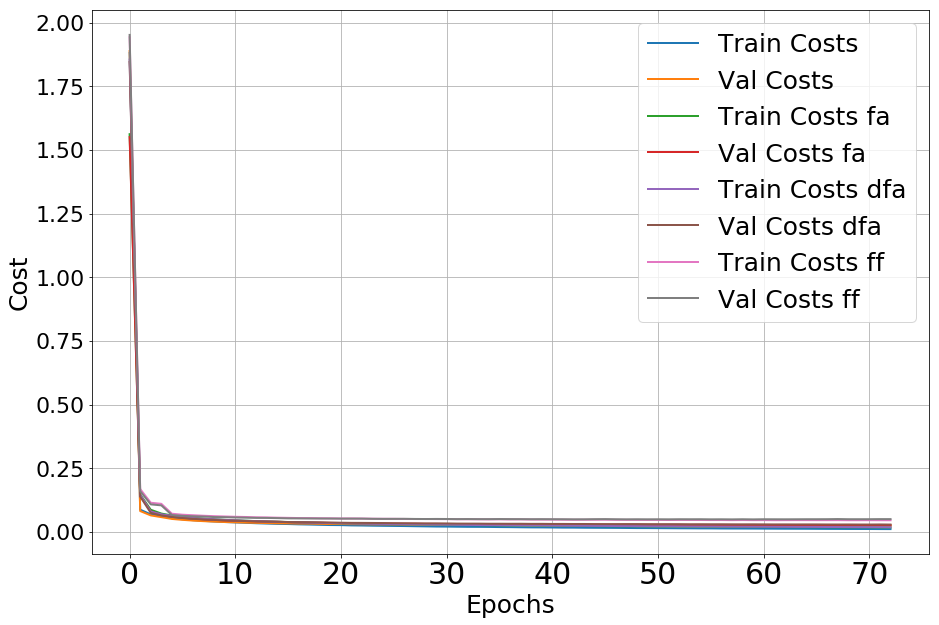

In [24]:
plt.plot(train_costs, label="Train Costs")
plt.plot(val_costs, label="Val Costs")
plt.plot(train_costs_r, label="Train Costs fa")
plt.plot(val_costs_r, label="Val Costs fa")
plt.plot(train_costs_df, label="Train Costs dfa")
plt.plot(val_costs_df, label="Val Costs dfa")
plt.plot(train_costs_ff, label="Train Costs ff")
plt.plot(val_costs_ff, label="Val Costs ff")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

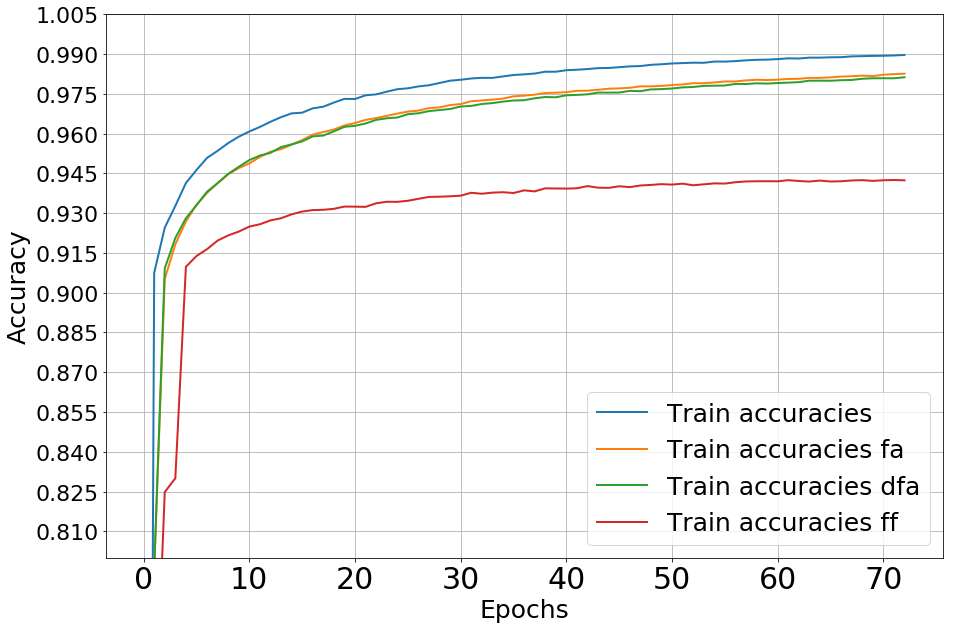

In [31]:
plt.plot(train_accuracies, label="Train accuracies")
#plt.plot(val_accuracies, label="Val accuracies")
plt.plot(train_accuracies_r, label="Train accuracies fa")
#plt.plot(val_accuracies_r, label="Val accuracies fa")
plt.plot(train_accuracies_df, label="Train accuracies dfa")
#plt.plot(val_accuracies_df, label="Val accuracies dfa")
plt.plot(train_accuracies_ff, label="Train accuracies ff")
#plt.plot(val_accuracies_ff, label="Val accuracies ff")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.015*i for i in range(1,120)])
plt.ylim(0.8,1.005)
plt.grid()
plt.legend()
plt.show()

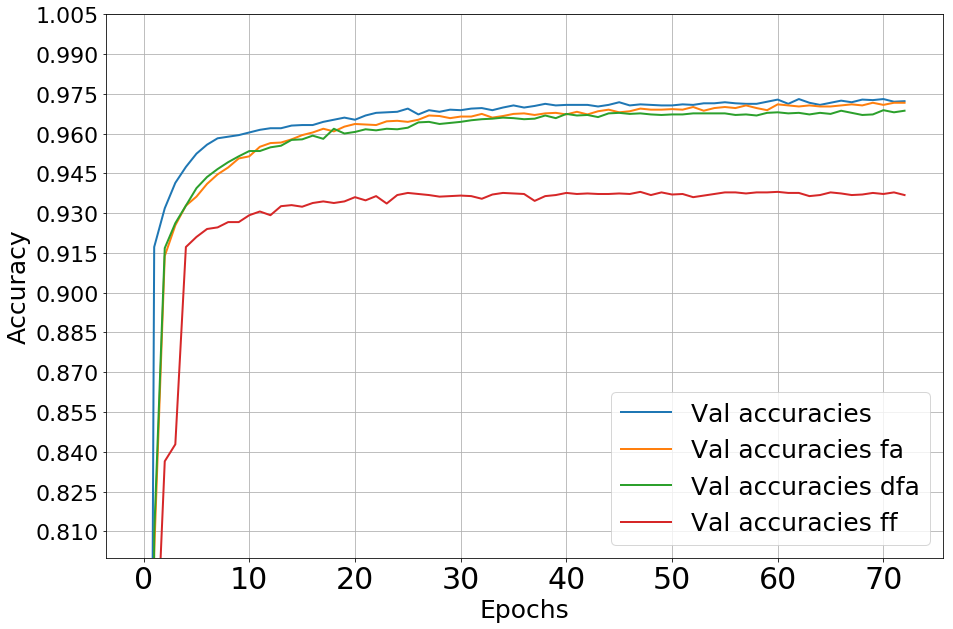

In [30]:
#plt.plot(train_accuracies, label="Train accuracies")
plt.plot(val_accuracies, label="Val accuracies")
#plt.plot(train_accuracies_r, label="Train accuracies fa")
plt.plot(val_accuracies_r, label="Val accuracies fa")
#plt.plot(train_accuracies_df, label="Train accuracies dfa")
plt.plot(val_accuracies_df, label="Val accuracies dfa")
#plt.plot(train_accuracies_ff, label="Train accuracies ff")
plt.plot(val_accuracies_ff, label="Val accuracies ff")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.015*i for i in range(1,120)])
plt.ylim(0.8,1.005)
plt.grid()
plt.legend()
plt.show()

path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/'
writer = tf.summary.FileWriter(path, sess.graph)
writer.flush()
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open(path+'/timeline.json', 'w') as f:
    f.write(ctf)


writer.add_run_metadata(run_metadata, 'mysess')
writer.flush()
writer.close()